<a href="https://colab.research.google.com/github/johnkevinoregan/Learning-Relations-with-Deep-Learning/blob/main/Brightness_Judgement_on_1D_retina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Left/Right judgement on 1D retina
##Create Training Examples with holes which are not trained

In [ ]:
#K Generate training samples
#PixToSkip is the number of retinal pixels inbetween two successive retinal locations where there can be a training sample. You can use the value 0 if you dont want to skip locations.
#LeftNumToTrain is the number of retinal locations on the left side of the retina you want to train
#NumInHole is the number of those retinal locations in the center of the retina where you choose not to train (in order to test generalization)
#RightNumToTrain is the number of retinal locations on the right side of the retina you want to train
#As an example : generate_training_set(0,4,0,4) generates a training set with a retina of size 8 where all locations will be trained (+'s) and there is no hole: ++++++++ 
#generate_training_set(0,4,3,4) does the same except now there is a hole where there is no training (.'s): ++++...++++ (the retina is now of length 11)
#generate_training_set(1,4,3,4) does the same again, except now there are also skipped pixels inbetween all the training locations: +.+.+.+......+.+.+.+

def generate_training_set(PixToSkip,LeftNumToTrain,NumInHole,RightNumToTrain): 
  TotNumToTrain=LeftNumToTrain+RightNumToTrain
  LastRetinaPixel=(TotNumToTrain+NumInHole-1)*(PixToSkip+1)
  Midpoint=LastRetinaPixel/2
  #print(Midpoint)
  X_trials=[[0 for col in range(LastRetinaPixel+1)] for row in range(TotNumToTrain)]
  StepInterval=PixToSkip+1
  i=0
  for j in range(LeftNumToTrain):
    retpos=j*StepInterval
    #print(i,retpos)
    X_trials[i][retpos]=1
    #print(X_trials[i])
    i+=1
    #print('left')
  #for j in range(NumInHole):
  #  retpos=(LeftNumToTrain+j)*StepInterval
  #  #print(i,retpos)
  #  X_trials[i][retpos]=1
  #  #print(X_trials[i])
  #  i+=1
  #  #print('hole')
  for j in range(RightNumToTrain):
    retpos=(LeftNumToTrain+NumInHole+j)*StepInterval
    #print(i,retpos)
    X_trials[i][retpos]=1
    #print(X_trials[i])
    i+=1
    #print('right')

  return(X_trials)

#K This function generates a list of all the possible tests 
#you give it the same parameters as for the training set so it can calculate how long the retina is
def generate_test_set(PixToSkip,LeftNumToTrain,NumInHole,RightNumToTrain):
  TotNumToTrain=LeftNumToTrain+RightNumToTrain
  RetinaSize=(TotNumToTrain+NumInHole-1)*(PixToSkip+1)+1
  AllPossTests=[[0 for row in range(RetinaSize)] for col in range(RetinaSize)]
  for i in range(RetinaSize):
     AllPossTests[i][i]=1
  return(AllPossTests)


# K generate labels based on the index of 1 in each row of the Training or Test set
def generate_labels(Set):
  Labels = [1 if row.index(1) >= (len(row)-1)/2 else 0 for row in Set]
  return Labels


In [ ]:
#K example of use of the functions
X_train=generate_training_set(2,10,10,10)
#np.random.shuffle(X_train)
y_train=generate_labels(X_train)
print('training set')
for i in range(len(X_train)):
  print(X_train[i], 'label', y_train[i])
print()

X_test=generate_test_set(2,10,10,10)
y_test=generate_labels(X_test)
print('test set')
for i in range(len(X_test)):
  print(X_test[i], 'label', y_test[i])
print()


In [ ]:
import numpy as np
#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
#from sklearn.model_selection import train_test_split

## Either: Train with normal NN

In [ ]:
from tensorflow import keras

In [ ]:
# Build the neural network model
#there are two hidden layers with 64 and 32 values
#The ReLU activation function is used in deep learning models to introduce non-linearity into the network
#the sigmoid activation function produces a probability value between 0 and 1
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_dim=len(X_train[0])),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
#Don't run this
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test))


## Or: Train with CNN

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(len(X_train[0]), 1)))
model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy:", accuracy)

##Test on Whole Retina and Plot results

In [ ]:
#Test on all retinal positions including non-trained ones
RetinaSize=len(X_test[0])
#results=[0 for col in range(RetinaSize)]
results=[0]*(RetinaSize)
counter=0
for i in range(RetinaSize):
  pred=model.predict(np.array([X_test[i]]))
  results[i]=pred[0][0]
  if results[i]<0.5:
    estimate=0
  else:
    estimate=1 

  if (y_test[i]==estimate):
    counter+=1

print(results)
print('count', counter, 'out of', RetinaSize+1, 'proportion', counter/(RetinaSize+1))



In [ ]:
import numpy as np
arr = np.array(results)
print(np.round(arr, decimals=2))

###Result for normal NN

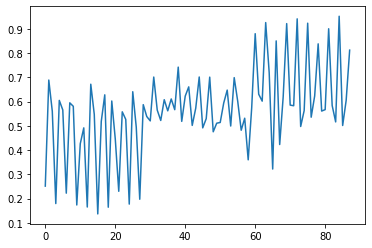

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results)

###Result for CNN with kernelsize=3

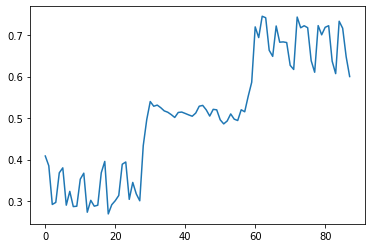

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results)